In [8]:
import hist
from hist import Hist, axis
import numpy as np

In [90]:
import numpy as np
import hist
from hist import Hist


# Function to rebin a histogram
def rebin(histogram, new_bins=None, reltol=None, abstol=None):
    # Check if at least one parameter is provided for rebinning
    if new_bins is None and reltol is None and abstol is None:
        raise ValueError("Either 'new_bins', 'reltol', or 'abstol' must be provided for rebinning.")

    # Process the new bins if provided
    if new_bins is not None:
        if not isinstance(new_bins, list):
            raise ValueError("'new_bins' must be a list or a list of lists.")
        if not all(isinstance(edges, list) for edges in new_bins):
            raise ValueError("If 'new_bins' is a list of lists, each element must be a list of bin edges.")
        # Create a dictionary mapping axis names to the new bin edges
        new_axes_dict = {axis.name: np.asarray(edges) for axis, edges in zip(histogram.axes, new_bins)}
    else:
        new_axes_dict = {}
    print(new_axes_dict)

    # Process each axis of the histogram
    for axis in histogram.axes:
        # If the axis name is not in the new_axes_dict, calculate new edges based on reltol or abstol
        if axis.name not in new_axes_dict:
            if reltol is not None and abstol is not None:
                raise ValueError("Only one of 'reltol' or 'abstol' should be provided.")
            elif reltol is not None:
                # Calculate new edges based on relative tolerance
                rel_edges = np.diff(axis.edges) * reltol
                print("elif1:", rel_edges)
                new_edges = axis.edges[:-1][np.where(rel_edges >= 0)]
                print("elif1:", new_edges)
                new_edges = np.concatenate([[axis.edges[0]], new_edges, [axis.edges[-1]]])
                print("elif1:", new_edges)
            elif abstol is not None:
                # Calculate new edges based on absolute tolerance
                new_edges = axis.edges[np.where(np.diff(axis.edges) >= abstol)]
                print("elif:", new_edges)
                new_edges = np.concatenate([[axis.edges[0]], new_edges, [axis.edges[-1]]])
                print("elif:", new_edges)
            else:
                # No rebinning needed for this axis
                new_edges = axis.edges
                print("else:", new_edges)
            # Update the new_axes_dict with the new edges
            new_axes_dict[axis.name] = new_edges
            print(new_axes_dict)

    # Calculate the new bin indices for each axis
    new_axes_indices = {
        axis.name: np.digitize(histogram.axes[axis.name].centers, new_axes_dict[axis.name]) - 1
        for axis in histogram.axes
    }
    print(f"new_axes_indices: {new_axes_indices}")

    # Define the slices for extracting the rebinned counts
    slices = tuple(
        slice(new_axes_indices[axis.name][i], new_axes_indices[axis.name][i+1] + 1)
        for i, axis in enumerate(histogram.axes)
    )
    print(f"slice: {slices}")

    # Extract the rebinned counts from the original histogram
    rebinned_counts = histogram.view(flow=True)[slices]
    print(f"rebinned_counts: {rebinned_counts}")

    # If no counts are present in the rebinned histogram, create an empty array with the correct shape
    if rebinned_counts.size == 0:
        rebinned_counts = np.empty(tuple(slice_.stop - slice_.start for slice_ in slices), dtype=histogram.values().dtype)

    # Create a new rebinned histogram with the updated bin edges
    rebinned_hist = Hist(
        *(hist.axis.Variable(new_axes_dict[axis.name]) if axis.name in new_axes_dict else axis for axis in histogram.axes)
    )
    # rebinned_hist.fill(*histogram.values())

    return rebinned_hist

In [115]:
def rebin_hist(h, **kwargs):
    import boost_histogram as bh
    for axis_name, edges in kwargs.items():
        if axis_name not in h.axes.label:
            raise ValueError(f"Undefined axis {axis_name}")

        if type(edges) == int:
            return h[{axis_name : bh.rebin(edges)}]
        elif all(type(edge) == float for edge in edges):
            ax = h.axes[axis_name]
            ax_idx = [a.name for a in h.axes].index(axis_name)
            if not all([np.isclose(x, ax.edges).any() for x in edges]):
                raise ValueError(f"Cannot rebin histogram due to incompatible edges for axis '{ax.name}'\n"
                                    f"Edges of histogram are {ax.edges}, requested rebinning to {edges}")
                
            # If you rebin to a subset of initial range, keep the overflow and underflow
            overflow = ax.traits.overflow or (edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1]))
            underflow = ax.traits.underflow or (edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0]))
            flow = overflow or underflow
            new_ax = hist.axis.Variable(edges, name=ax.name, overflow=overflow, underflow=underflow)
            axes = list(h.axes)
            axes[ax_idx] = new_ax
            
            hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())
        
            # Offset from bin edge to avoid numeric issues
            offset = 0.5*np.min(ax.edges[1:]-ax.edges[:-1])
            edges_eval = edges+offset
            edge_idx = ax.index(edges_eval)
            # Avoid going outside the range, reduceat will add the last index anyway
            if edge_idx[-1] == ax.size+ax.traits.overflow:
                edge_idx = edge_idx[:-1]
        
            if underflow:
                # Only if the original axis had an underflow should you offset
                if ax.traits.underflow:
                    edge_idx += 1
                edge_idx = np.insert(edge_idx, 0, 0)
        
            # Take is used because reduceat sums i:len(array) for the last entry, in the case
            # where the final bin isn't the same between the initial and rebinned histogram, you
            # want to drop this value. Add tolerance of 1/2 min bin width to avoid numeric issues
            hnew.values(flow=flow)[...] = np.add.reduceat(h.values(flow=flow), edge_idx, 
                    axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
            if hnew.storage_type() == hist.storage.Weight():
                hnew.variances(flow=flow)[...] = np.add.reduceat(h.variances(flow=flow), edge_idx, 
                        axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
        elif all(type(edge) == int for edge in edges):
            # implement grouping of bins here            
            pass
        else:
            raise ValueError("The new bin edges should be a list of integers or a list of floats")
    return hnew

In [54]:
h = Hist(axis.Regular(10, 0, 1, name="x"), name="hist")

In [55]:
h

Hist(Regular(10, 0, 1, name='x'), storage=Double())

In [56]:
h.fill(x=np.random.normal(size=1_000_000))

Hist(Regular(10, 0, 1, name='x'), storage=Double()) # Sum: 341569.0 (1000000.0 with flow)

In [107]:
integrate_hist(h, x=3)

37622.0

In [94]:
type(h[::rebin_hist(2)])

TypeError: rebin_hist() missing 2 required positional arguments: 'axis_name' and 'edges'

In [93]:
rebinned_hist1 = rebin(h, new_bins=[[0, 1], [2, 3 ,4], [5]], reltol=None, abstol=None)

{'x': array([0, 1])}
new_axes_indices: {'x': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
slice: (slice(0, 1, None),)
rebinned_counts: [499814.]


In [65]:
rebinned_hist1

Hist(Variable([0, 0.5, 0.7, 1], label='Axis 0'), storage=Double())

In [114]:
n = rebin_hist(h, x=[0., 0.3, 0.4, 1.])
n

/var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_92583/966693331.py:24: DeprecationWarning: Accessing storage type has changed from _storage_type to storage_type, and will be removed in future.
  hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())
/var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_92583/966693331.py:45: DeprecationWarning: Accessing storage type has changed from _storage_type to storage_type, and will be removed in future.
  if hnew._storage_type() == hist.storage.Weight():


Hist(Variable([0, 0.3, 0.4, 1], name='x'), storage=Double()) # Sum: 341569.0 (1000000.0 with flow)

n.axes, h.axes

In [73]:
h.view(flow=True)[0:1], h.values()

(array([499814.]),
 array([39987., 39353., 38956., 37622., 36103., 34453., 32256., 30020.,
        27562., 25257.]))

In [104]:
h[{"x": 5j}]

159014.0

In [109]:
h[::5j]  # x from .3 to the end, y is rebinned by 2

Hist(Regular(2, 0, 1, name='x', label='x-axis'), storage=Double()) # Sum: 341549.0 (1000000.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x1201cabd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

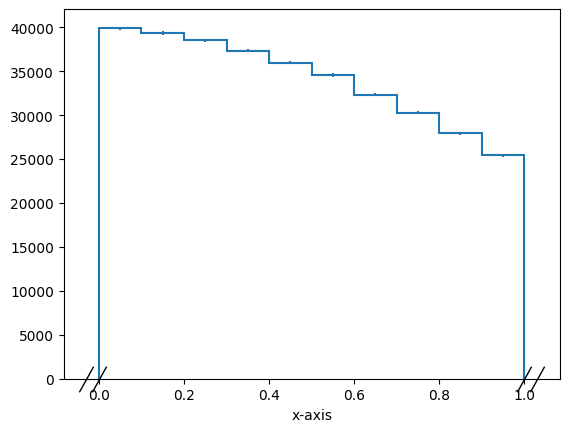

In [110]:
h.plot()

In [111]:
h.plot2d_full()

TypeError: Only 2D-histogram has plot2d_full

In [127]:
from hist import loc, rebin, sum

In [152]:
?rebin

Init signature: rebin(value: 'int') -> 'None'
Docstring:      <no docstring>
File:           /opt/homebrew/lib/python3.11/site-packages/boost_histogram/tag.py
Type:           type
Subclasses:     


In [129]:
h[2:3:sum]

38501.0

In [134]:
h[{0: slice(2, 9, 2j)}] # rebin axis 0 by two

Hist(Regular(3, 0.2, 0.8, name='x', label='x-axis'), storage=Double()) # Sum: 208987.0 (1000000.0 with flow)